In [3]:
import ROOT
from math import pow, sqrt

Welcome to JupyROOT 6.30/04


In [89]:
# Measure EMu trigger efficiency, electron leg
WORKDIR = "/home/choij/workspace/ChargedHiggsAnalysisV2"
ERA = "2016preVFP"
HLT = "Mu8El23"

In [90]:
def get_histograms(hltkey: ROOT.TString, syst: ROOT.TString, is_data: bool) -> (ROOT.TH2D, ROOT.TH2D):
    if is_data:
        f = ROOT.TFile.Open(f"{WORKDIR}/SKFlatOutput/MeasTrigEff/{ERA}/MeasElLegs__/DATA/MeasTrigEff_SingleMuon.root")
    elif syst == "AltMC":
        f = ROOT.TFile.Open(f"{WORKDIR}/SKFlatOutput/MeasTrigEff/{ERA}/MeasElLegs__/MeasTrigEff_DYJets.root")
    else:
        f = ROOT.TFile.Open(f"{WORKDIR}/SKFlatOutput/MeasTrigEff/{ERA}/MeasElLegs__/MeasTrigEff_TTLL_powheg.root")
        
    if syst == "AltTag":
        h_denom = f.Get(f"TrigEff_{hltkey}_ElLeg_DENOM/{syst}/fEta_Pt"); h_denom.SetDirectory(0)
        h_num = f.Get(f"TrigEff_{hltkey}_ElLeg_NUM/{syst}/fEta_Pt"); h_num.SetDirectory(0)
    else:
        h_denom = f.Get(f"TrigEff_{hltkey}_ElLeg_DENOM/Central/fEta_Pt"); h_denom.SetDirectory(0)
        h_num = f.Get(f"TrigEff_{hltkey}_ElLeg_NUM/Central/fEta_Pt"); h_num.SetDirectory(0)
    f.Close()
    
    return (h_num, h_denom)

def get_efficiency(key, h_num, h_denom):
    h_eff = h_num.Clone(f"Eff_{key}"); h_eff.Reset()
    for bin in range(1, h_num.GetNcells()+1):
        # get bin contents and stat errors
        num, err_num = h_num.GetBinContent(bin), h_num.GetBinError(bin)
        denom, err_denom = h_denom.GetBinContent(bin), h_denom.GetBinError(bin)
        if denom == 0 or num == 0:
            eff, err = 0., 0.
        else:
            eff = num / denom
            err = eff*sqrt(pow(err_num/num, 2) + pow(err_denom/denom, 2))
        h_eff.SetBinContent(bin, eff)
        h_eff.SetBinError(bin, err)
    h_eff.SetDirectory(0)
    return h_eff

In [91]:
# Calculate efficiency for data
h_num, h_denom = get_histograms(HLT, "Central", True)
h_num_alttag, h_denom_alttag = get_histograms(HLT, "AltTag", True)
h_eff_data_central = get_efficiency(f"{HLT}_Data_Central", h_num, h_denom)
h_eff_data_alttag = get_efficiency(f"{HLT}_Data_AltTag", h_num_alttag, h_denom_alttag)

h_eff_data = h_eff_data_central.Clone(f"{HLT}_Data"); h_eff_data.Reset()
# Calculate bin by bin error
for bin in range(1, h_eff_data.GetNcells()+1):
    diff = h_eff_data_alttag.GetBinContent(bin) - h_eff_data_central.GetBinContent(bin)
    stat = h_eff_data_central.GetBinError(bin)
    total = sqrt(pow(diff, 2) + pow(stat, 2))
    h_eff_data.SetBinContent(bin, h_eff_data_central.GetBinContent(bin))
    h_eff_data.SetBinError(bin, total)

In [92]:
# Calcualte efficiency for MC
h_num, h_denom = get_histograms(HLT, "Central", False)
h_num_alttag, h_denom_alttag = get_histograms(HLT, "AltTag", False)
h_num_altmc, h_denom_altmc = get_histograms(HLT, "AltMC", False)
h_eff_mc_central = get_efficiency(f"{HLT}_MC_Central", h_num, h_denom)
h_eff_mc_alttag = get_efficiency(f"{HLT}_MC_AltTag", h_num_alttag, h_denom_alttag)
h_eff_mc_altmc = get_efficiency(f"{HLT}_MC_AltMC", h_num_altmc, h_denom_altmc)

h_eff_sim = h_eff_mc_central.Clone(f"{HLT}_MC"); h_eff_sim.Reset()
# Calculate bin by bin error
for bin in range(1, h_eff_sim.GetNcells()+1):
    diff_alttag = h_eff_mc_alttag.GetBinContent(bin) - h_eff_mc_central.GetBinContent(bin)
    diff_altmc = h_eff_mc_altmc.GetBinContent(bin) - h_eff_mc_central.GetBinContent(bin)
    stat = h_eff_mc_central.GetBinError(bin)
    total = sqrt(pow(diff_alttag, 2) + pow(diff_altmc, 2) + pow(stat, 2))
    h_eff_sim.SetBinContent(bin, h_eff_mc_central.GetBinContent(bin))
    h_eff_sim.SetBinError(bin, total)

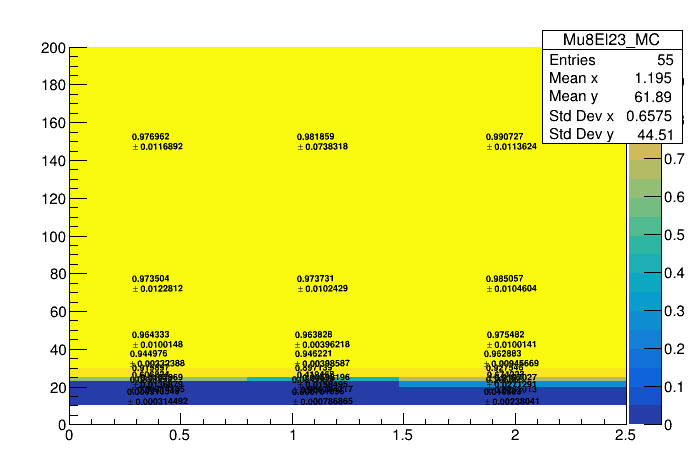

In [93]:
c = ROOT.TCanvas()
c.cd()
h_eff_sim.Draw("colztexte")
c.Draw()

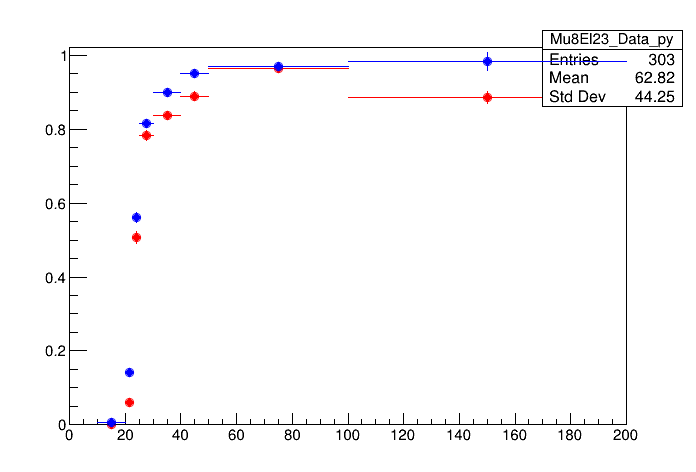

In [94]:
# Draw Eta averaged efficiency vs PT -> Projection to y axis
h_eff_data_projy = h_eff_data.ProjectionY()
for j in range(1, h_eff_data_projy.GetNbinsX()+1):
    sum = 0
    for i in range(1, h_eff_data.GetNbinsX()+1):
        sum += h_eff_data.GetBinError(i, j)
    h_eff_data_projy.SetBinError(j, sum)
h_eff_data_projy.Scale(1./4)

h_eff_sim_projy = h_eff_sim.ProjectionY()
for j in range(1, h_eff_sim_projy.GetNbinsX()+1):
    sum = 0
    for i in range(1, h_eff_sim.GetNbinsX()+1):
        sum += h_eff_sim.GetBinError(i, j)
    h_eff_sim_projy.SetBinError(j, sum)
h_eff_sim_projy.Scale(1./4)

c2 = ROOT.TCanvas()
c2.cd()
h_eff_data_projy.SetMarkerStyle(20)
h_eff_data_projy.SetMarkerColor(ROOT.kRed)
h_eff_data_projy.SetLineColor(ROOT.kRed)
h_eff_data_projy.Draw("pe")
h_eff_sim_projy.SetMarkerStyle(20)
h_eff_sim_projy.SetMarkerColor(ROOT.kBlue)
h_eff_sim_projy.SetLineColor(ROOT.kBlue)
h_eff_sim_projy.Draw("pesame")
c2.Draw()
